# Proyecto - Procesamiento de lenguaje natural
En este notebook se realiza una limpieza final de los datos recolectados y una división para las diferentes pruebas que se harán. En particular, se crearán cuatro datasets consolidados para Wayuu:
- **Completo:** Contiene todos los datos encontrados de la biblia, constitución, cuentos y diccionarios.
- **Completo sin la constitución:** Dado que la limpieza de los datos de la constitución se ralizó de forma manual, se probará cómo afecta sacar este dataset del corpus de entrenamiento y prueba.
- **Completo sin el diccionario completo:** El diccionario fue un input posterior a la creación del corpus en la primera entrega. Este diccionario se obtuvo de de la página [https://osf.io/6kbze/](https://osf.io/6kbze/). Para evaluar los resultados sin este diccionario se creará un corpus que contenga únicamente textos encontrados en la primera entrega.
- **Completo sin el diccionario de palabras solas:** Dado que el diccionario contiene anto palabras solas (por ejemplo: hola,jamaan) como frases, se evaluará el impacto de estas palabras solas en la tarea de traducción.

Por otro lado, para el Arhuaco tenemos menos datos, por lo que se crearán los siguientes datasets:
- **Completo:** Contiene los datos de la biblia, la constitución y cuentos.
- **Sin la constitución**: Contiene los datos completos sin la constitución dado que, al igual que para el Wayuu, la constitución se realizó de forma manual.
- **Únicamente la biblia**: Contiene los datos completos sin la constitución y sin los cuentos encontrados. Estos representan pocos datos por lo que veremos el impacto de tenerlos o no en el corpus.

# Librerías

In [69]:
!pip install unidecode

In [105]:
# Textos
import re
from unidecode import unidecode

# Datos
import pickle
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

In [71]:
path = '/content/drive/MyDrive/Colab Notebooks/Talleres NLP/Proyecto/data_raw'

In [101]:
path_out = '/content/drive/MyDrive/Colab Notebooks/Talleres NLP/Proyecto/data_clean'

# Wayuu

### Lectura de datos

In [85]:
# Leemos los datos wayuu
data_sets_wayuu = {}
for ds in glob(path + '/wayuu/*'):
  name = ds.split('/')[-1].split('.')[0]
  data_sets_wayuu[name] = pd.read_csv(ds)

# Vemos los datasets que hay
data_sets_wayuu.keys()

dict_keys(['diccionario', 'traduccion_AT', 'traduccion_constitucion', 'traduccion_cuento_wayuu', 'traduccion_NT'])

In [86]:
# Consolidación del dataset de la biblia (antiguo testamento + nuevo testamento)
data_sets_wayuu['biblia'] = pd.concat([data_sets_wayuu.pop('traduccion_AT'), data_sets_wayuu.pop('traduccion_NT')])

# Vemos los datasets que hay
data_sets_wayuu.keys()

dict_keys(['diccionario', 'traduccion_constitucion', 'traduccion_cuento_wayuu', 'biblia'])

### Limpieza

In [87]:
# Función para limpieza

def clean_text(text: str)->str:
  """
  Realiza una limpieza del texto. Pasa el texto a minúsculas, elimina números al inicio de las frases
  (pueden deberse a el número de versículo de la biblia), elimina caracteres no alfa-numéricos y por último
  reemplaza los números por un token especial NUM.

  input:
  - text: texto a limpiar

  output:
  - clean_text: texto limpio
  """
  # Pasar a minúsculas y quitar espacios antes y después
  clean_text = text.lower().strip()

  # Quitamos tildes
  clean_text = unidecode(clean_text)

  # Eliminar números al inicio de las frases
  patron = re.compile(r'^\d+')
  clean_text = patron.sub('', clean_text).strip()

  # Eliminar caracteres no alfa numéricos.
  # Dejamos algunos como el ' que es importante en las lenguas, los puntos y las comas
  clean_text = re.sub(r'[^a-z0-9\s,.\'\ʼü]', ' ', clean_text)

  # Agregamos el token NUM para números
  clean_text = re.sub(r'\d+', 'NUM', clean_text)

  return clean_text

In [88]:
# Cambiamos el nombre de las columnas del diccionario
data_sets_wayuu['diccionario'].rename(columns = {'spa': 'esp', 'guc': 'wayuu'}, inplace = True)

In [89]:
# Veamos cómo están los datos antes
data_sets_wayuu['biblia'].head()

,wayuu,esp
0,"0 Je tü jososhiipaʼakat, niʼitaain “Mmain” sün...","Cuando Dios, en el principio,creó los cielos y..."
1,maaʼinyatuuisü tü mmakat sümaa manouktuuyuliai...,la tierra era una masa caóticay las tinieblas ...
2,"“Anakaja warattuuliraa sümüle”, nümakalaka chi...",Entonces dijo Dios:—¡Que exista la luz!Y la lu...
3,"Je süka eeitpain warattuui, talatüshi maʼi chi...","Al ver Dios que la luz era buena,la separó de ..."
4,"Je tü warattuuliikat, niʼitaain “kaʼin” sünüli...","llamando a la luz «día»y a las tinieblas, «noc..."


In [90]:
# Limpiamos todos los textos que tenemos
for key, ds in data_sets_wayuu.items():
  ds.dropna(inplace = True)
  ds['esp'] = ds['esp'].apply(clean_text)
  ds['wayuu'] = ds['wayuu'].apply(clean_text)
  data_sets_wayuu[key] = ds[['esp', 'wayuu']]

In [91]:
# Veamos cómo quedaron los datos
data_sets_wayuu['biblia'].head()

,esp,wayuu
0,"cuando dios, en el principio,creo los cielos y...","je tu jososhiipa'akat, ni'itaain mmain sunul..."
1,la tierra era una masa caoticay las tinieblas ...,maa'inyatuuisu tu mmakat sumaa manouktuuyuliai...
2,entonces dijo dios que exista la luz y la l...,"anakaja warattuuliraa sumule , numakalaka chi..."
3,"al ver dios que la luz era buena,la separo de ...","je suka eeitpain warattuui, talatushi ma'i chi..."
4,"llamando a la luz dia y a las tinieblas, ...","je tu warattuuliikat, ni'itaain ka'in sunuli..."


### Separar

In [93]:
# Dataset completo
data_set_completo = pd.concat([data_sets_wayuu['biblia'],
                      data_sets_wayuu['traduccion_constitucion'],
                      data_sets_wayuu['traduccion_cuento_wayuu'],
                      data_sets_wayuu['diccionario']]).drop_duplicates()

data_set_completo.shape

(81415, 2)

In [94]:
# Sin constitución
sin_constitucion = pd.concat([data_sets_wayuu['biblia'],
                      data_sets_wayuu['traduccion_cuento_wayuu'],
                      data_sets_wayuu['diccionario']]).drop_duplicates()

sin_constitucion.shape

(81284, 2)

In [95]:
# Sin diccionario
sin_diccionario = pd.concat([data_sets_wayuu['biblia'],
                      data_sets_wayuu['traduccion_constitucion'],
                      data_sets_wayuu['traduccion_cuento_wayuu']]).drop_duplicates()

sin_diccionario.shape

(8939, 2)

In [100]:
# Sin diccionario de palabras solas
dic = data_sets_wayuu['diccionario']
num_palabras = dic.esp.apply(lambda x: len(x.split(' ')))

diccionario_sin_palabras_unicas = dic[num_palabras > 1]

sin_palabras_unicas_diccionario = pd.concat([data_sets_wayuu['biblia'],
                      data_sets_wayuu['traduccion_constitucion'],
                      data_sets_wayuu['traduccion_cuento_wayuu'],
                      diccionario_sin_palabras_unicas]).drop_duplicates()

sin_palabras_unicas_diccionario.shape

(79248, 2)

### Guardar

In [102]:
#data_set_completo.to_csv(path_out + '/wayuu/COMP.csv', index = None)
#sin_constitucion.to_csv(path_out + '/wayuu/COMP_NC.csv', index = None)
#sin_diccionario.to_csv(path_out + '/wayuu/COMP_ND.csv', index = None)
#sin_palabras_unicas_diccionario.to_csv(path_out + '/wayuu/COMP_NDU.csv', index = None)

# Arhuaco

### Lectura de datos

In [121]:
# Leemos los datos wayuu

data_sets_arhuaco = {}
for ds in glob(path + '/arhuaco/*'):
  name = ds.split('/')[-1].split('.')[0]
  if 'csv' in ds:
    data_sets_arhuaco[name] = pd.read_csv(ds)
  elif 'pickle' in ds:
    with open(ds, 'rb') as file:
      data_sets_arhuaco[name] = pd.DataFrame(pickle.load(file))

# Vemos los datasets que hay
data_sets_arhuaco.keys()

dict_keys(['cuento_traduccion', 'constitucion_arahuaco', 'cantos_traduccion', 'biblia_arahuaco'])

### Limpieza
Utilizamos la misma limpieza que para wayuu. Primero arreglamos los formatos de los dataframes.

In [122]:
# Corrección de columnas

correccion_columnas = {'arahuaco': 'arh', 'wayuu': 'arh'}
for key, df in data_sets_arhuaco.items():
  data_sets_arhuaco[key] = df.rename(columns = correccion_columnas)

In [124]:
# Vemos cómo se ven antes
data_sets_arhuaco['biblia_arahuaco'].head()

,arh,esp
0,Joseri chʉwí ʉnkʉnisi a'mechʉkwey a'zanu' nánʉ...,No pudiendo ya contener la emoción ante los qu...
1,"Joseri kúmʉ a'nisi ʉnmʉwari, egipsiw ɉinase' a...",Rompió a llorar tan fuerte que lo oyeron los e...
2,"Joseri: —“Nʉndi, José nanu'kinarwe, ¿Nʉkakʉri ...",Entonces José dijo a sus hermanos:—Yo soy José...
3,Josese'ri: —“Umʉn mʉchey nʉka'nakow” key mʉche...,Pero él les dijo:—¡Acérquense!Ellos se acercar...
4,"“Ʉwe'ki gwamʉ re'si nʉnhageynáchʉka, chʉwí ʉnk...",Pero no se aflijan ni se reprochen el haberme ...


In [125]:
# Limpieza

for key, ds in data_sets_arhuaco.items():
  ds.dropna(inplace = True)
  ds['esp'] = ds['esp'].apply(clean_text)
  ds['arh'] = ds['arh'].apply(clean_text)
  data_sets_arhuaco[key] = ds[['esp', 'arh']]

In [126]:
# Vemos cómo se ven después de la limpieza
data_sets_arhuaco['biblia_arahuaco'].head()

,esp,arh
0,no pudiendo ya contener la emocion ante los qu...,joseri chuwi unkunisi a'mechukwey a'zanu' nanu...
1,rompio a llorar tan fuerte que lo oyeron los e...,"joseri kumu a'nisi unmuwari, egipsiw jinase' a..."
2,entonces jose dijo a sus hermanos yo soy jos...,"joseri nundi, jose nanu'kinarwe, nukakuri..."
3,pero el les dijo acerquense ellos se acerca...,josese'ri umun muchey nuka'nakow key much...
4,pero no se aflijan ni se reprochen el haberme ...,"uwe'ki gwamu re'si nunhageynachuka, chuwi unk..."


### Separar

In [127]:
data_sets_arhuaco.keys()

dict_keys(['cuento_traduccion', 'constitucion_arahuaco', 'cantos_traduccion', 'biblia_arahuaco'])

In [128]:
# Dataset completo
data_set_completo_arh = pd.concat([data_sets_arhuaco['cuento_traduccion'],
                      data_sets_arhuaco['constitucion_arahuaco'],
                      data_sets_arhuaco['cantos_traduccion'],
                      data_sets_arhuaco['biblia_arahuaco']]).drop_duplicates()

data_set_completo_arh.shape

(5735, 2)

In [129]:
# Dataset sin la consititucion
sin_constitucion_arh = pd.concat([data_sets_arhuaco['cuento_traduccion'],
                      data_sets_arhuaco['cantos_traduccion'],
                      data_sets_arhuaco['biblia_arahuaco']]).drop_duplicates()

sin_constitucion_arh.shape

(5624, 2)

In [130]:
# Dataset solo con la biblia
biblia_arh = pd.concat([data_sets_arhuaco['biblia_arahuaco']]).drop_duplicates()

biblia_arh.shape

(5563, 2)

### Guardar

In [131]:
#data_set_completo_arh.to_csv(path_out + '/arhuaco/COMP.csv', index = None)
#sin_constitucion_arh.to_csv(path_out + '/arhuaco/COMP_NC.csv', index = None)
#biblia_arh.to_csv(path_out + '/arhuaco/BIBLIA.csv', index = None)

# Gráficos de resumen para el artículo

In [149]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("whitegrid")


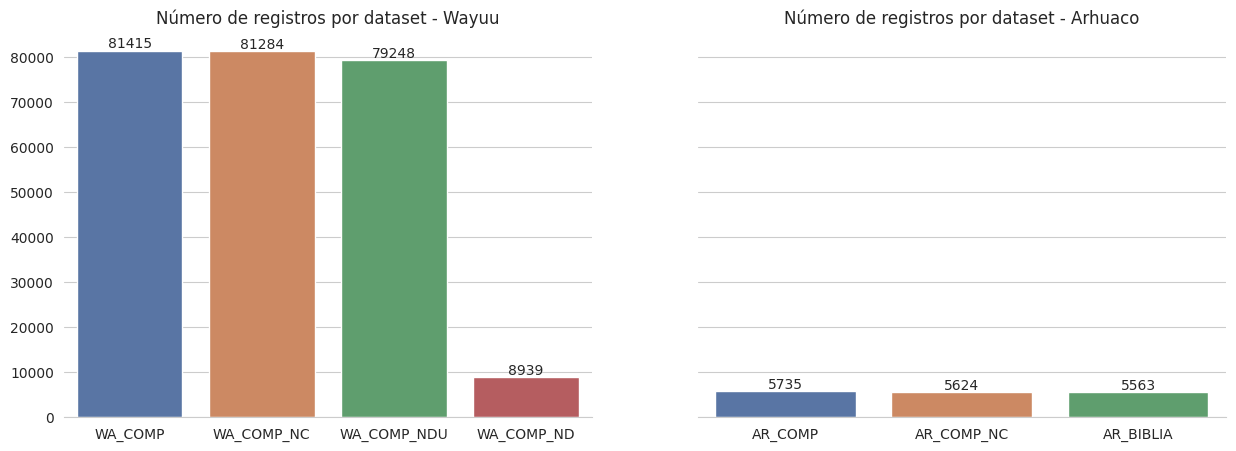

In [157]:
wayuu_num_datos = {'WA_COMP': data_set_completo.shape[0],
                   'WA_COMP_NC': sin_constitucion.shape[0],
                   'WA_COMP_NDU': sin_palabras_unicas_diccionario.shape[0],
                   'WA_COMP_ND': sin_diccionario.shape[0]}

arhuaco_num_datos = {'AR_COMP': data_set_completo_arh.shape[0],
                     'AR_COMP_NC': sin_constitucion_arh.shape[0],
                     'AR_BIBLIA': biblia_arh.shape[0]}

fig, axes = plt.subplots(ncols = 2, sharey = True, figsize = (15,5))

sns.barplot(x = list(wayuu_num_datos.keys()), y = list(wayuu_num_datos.values()), ax = axes[0], palette="deep")
axes[0].bar_label(axes[0].containers[0])
axes[0].set_title('Número de registros por dataset - Wayuu')

sns.barplot(x = list(arhuaco_num_datos.keys()), y = list(arhuaco_num_datos.values()), ax = axes[1], palette="deep")
axes[1].bar_label(axes[1].containers[0])
axes[1].set_title('Número de registros por dataset - Arhuaco')

sns.despine(left=True)

fig.savefig(path_out + "/num_datos.png")